<a href="https://colab.research.google.com/github/csabiu/KAML-2025/blob/main/GZ_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the necessary packages



In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

print(tf.__version__)

2.18.0


#Download data sample

In [3]:
!wget -q https://github.com/csabiu/ML_tutorial/blob/master/class.tar.gz.parta{a,b,c,d,e,f,g,h,i}?raw=true > tmp
!cat class.tar.gz.parta*true > class.tar.gz
!gunzip class.tar.gz
!tar -xvf class.tar > tmp
!rm class.tar*
!rm tmp
!ls

class  sample_data


## Lets look at an image



(424, 424, 3)


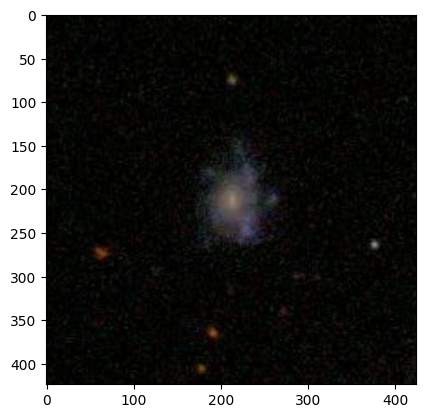

In [4]:
jpgfile = Image. open("class/100134.jpg")
plt.imshow(jpgfile)
print(np.shape(jpgfile))


# Lets crop it

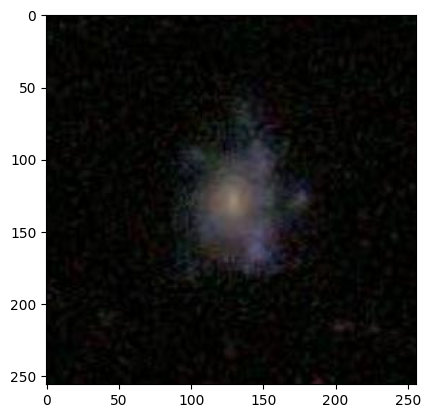

In [5]:
plt.imshow(jpgfile.crop((84,84,340,340)))

# And lower the resolution

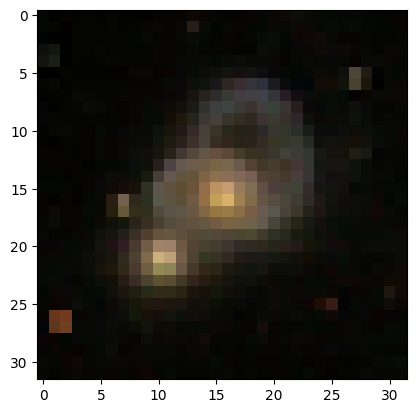

In [67]:
target_size = 32
plt.imshow(jpgfile.crop((112,112,312,312)).resize((target_size,target_size),Image.Resampling.LANCZOS))


# Split into RGB colors

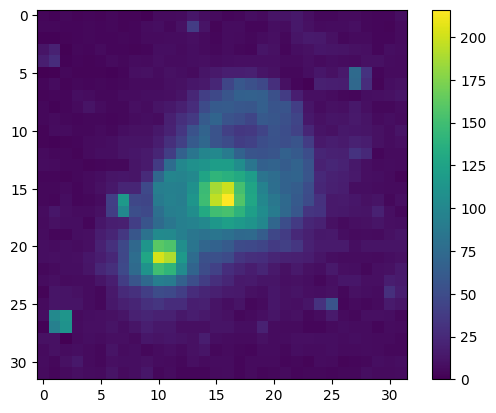

In [68]:
r,g,b=jpgfile.split()
plt.imshow(r.crop((112,112,312,312)).resize((target_size,target_size),Image.Resampling.LANCZOS))
plt.colorbar()

# Normalise the pixel values to (0,1)

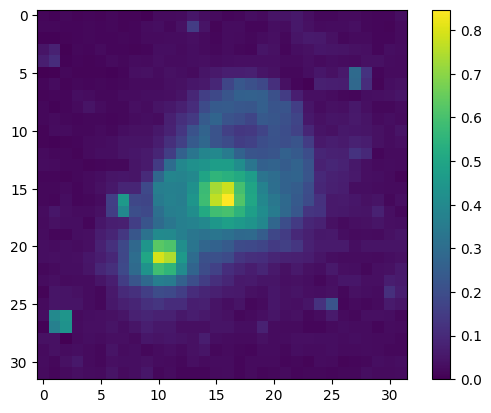

In [69]:
im=np.zeros((target_size,target_size))
im[:,:]=r.crop((112,112,312,312)).resize((target_size,target_size),Image.Resampling.LANCZOS)
im=im/255.
plt.imshow(im)
plt.colorbar()

# Load the labels (truth) data

(Image ID, galaxy type) - 0=smooth, 1=featured

In [70]:
data=np.loadtxt("class/truth.txt",dtype='i')
print(np.shape(data))
labels=data[:,1]

print(data[1:10,:]) # print first 10 entries

(16885, 2)
[[100134      1]
 [100322      1]
 [100380      1]
 [100458      0]
 [100479      0]
 [100520      1]
 [100672      0]
 [100673      1]
 [100724      0]]


<ipython-input-70-cda73ee8ae0c>:1: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  data=np.loadtxt("class/truth.txt",dtype='i')


# Lets transform all the images and save into an array

In [81]:
images=np.zeros((16885,target_size,target_size,3))
nn=0

for i in (data[:,0]):
  filename=str(int(i))+".jpg"
  jpgfile = Image. open("./class/"+filename)
  images[nn,:,:,:]=jpgfile.crop((112,112,312,312)).resize((target_size,target_size),Image.Resampling.LANCZOS)
  nn=nn+1

images=images/255.
print(np.shape(images))

# remove color - make each chanel the same
images[:,:,:,0]=images[:,:,:,1]
images[:,:,:,2]=images[:,:,:,1]
print(np.shape(images))

(16885, 32, 32, 3)
(16885, 32, 32, 3)


# Split images and labels into training and test data

In [82]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.4, random_state=42)

print(np.shape(train_data))
print(np.shape(train_label))
print(np.shape(test_data))
print(np.shape(test_label))

(10131, 32, 32, 3)
(10131,)
(6754, 32, 32, 3)
(6754,)


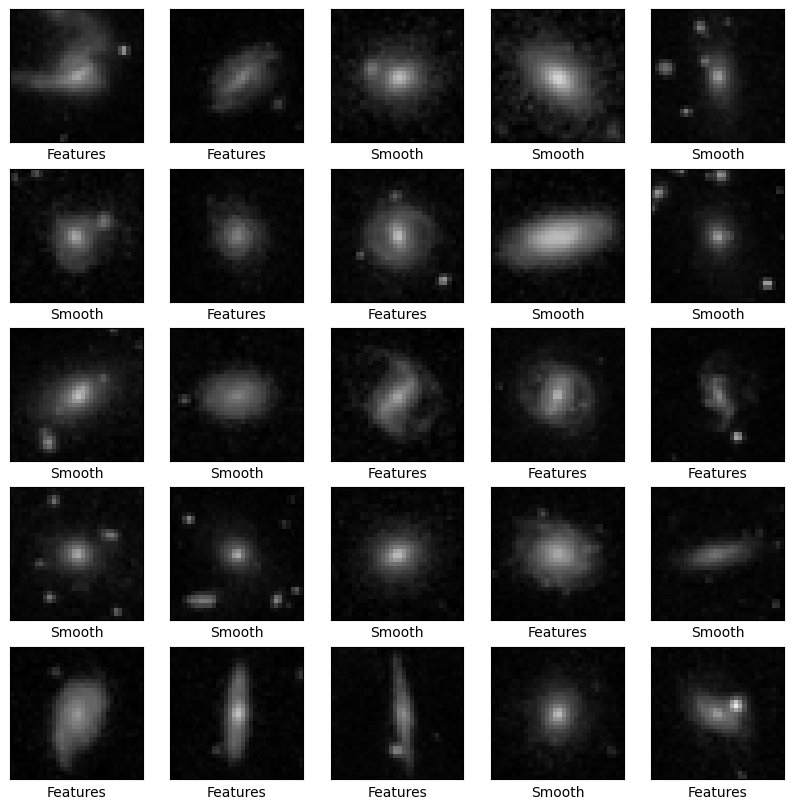

In [83]:
class_names = ['Smooth', 'Features']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(train_label[i])])
plt.show()

# Define a simple neural network

In [84]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(target_size, target_size, 3)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)])
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,802 (768.76 KB)

 Trainable params: 196,802 (768.76 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
hist = model.fit(train_data, train_label, epochs=15, validation_split=0.2)

Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6115 - loss: 0.6581 - val_accuracy: 0.6714 - val_loss: 0.6298
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6942 - loss: 0.5816 - val_accuracy: 0.7119 - val_loss: 0.5798
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7400 - loss: 0.5389 - val_accuracy: 0.7375 - val_loss: 0.5554
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7592 - loss: 0.5250 - val_accuracy: 0.7632 - val_loss: 0.5385
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7782 - loss: 0.5044 - val_accuracy: 0.7829 - val_loss: 0.5225
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7942 - loss: 0.4893 - val_accuracy: 0.7701 - val_loss: 0.5252
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7986 - loss: 0.4800 - val_accuracy: 0.7889 - val_loss: 0.5080
Epoch 8/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8067 - loss: 0.4656 - val_accuracy: 0.

In [86]:
test_loss, test_acc = model.evaluate(test_data, test_label)
print('Test accuracy:', test_acc)

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8012 - loss: 0.4626
Test accuracy: 0.8113710284233093


Set up some of plotting functions

Text(0.5, 0, 'Epoch')

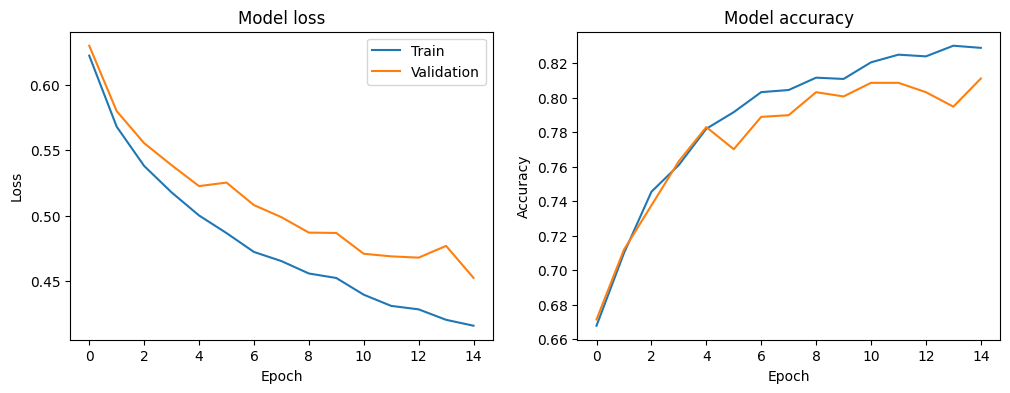

In [87]:
# plot training loss and accuracy history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [88]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[int(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([0,1])
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  #f, axarr = plt.subplots(2, sharex=True)
  #axarr[0].set_xticklabels(['smooth', 'features'])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# Make predictions on test data from the trained model

In [89]:
predictions = (model.predict(test_data[:,:,:]))

print("First 10 galaxies")
print("Predicted:",np.argmax(predictions[1:11],axis=1))
print("Truth:    ",np.int_(test_label[1:11]))

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
First 10 galaxies
Predicted: [0 0 0 0 0 0 1 1 0 1]
Truth:     [0 0 0 0 0 0 1 1 0 1]


# Lets visialise these classifications

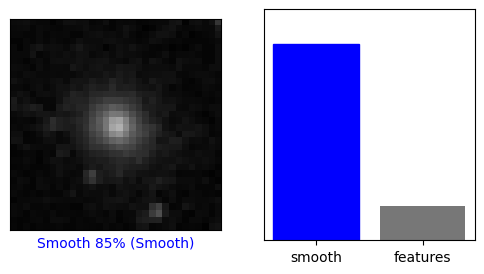

In [90]:
i = 4
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, np.int_(test_label), test_data)
f=plt.subplot(1,2,2)
plot_value_array(i, predictions,  np.int_(test_label))
f.axes.set_xticklabels(["smooth","features"])
plt.show()

 Plot the first X test images, their predicted label, and the true label
 Color correct predictions in blue, incorrect predictions in red

<ipython-input-91-f91c5e896f27>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-91-f91c5e896f27>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-91-f91c5e896f27>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-91-f91c5e896f27>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-91-f91c5e896f27>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLo

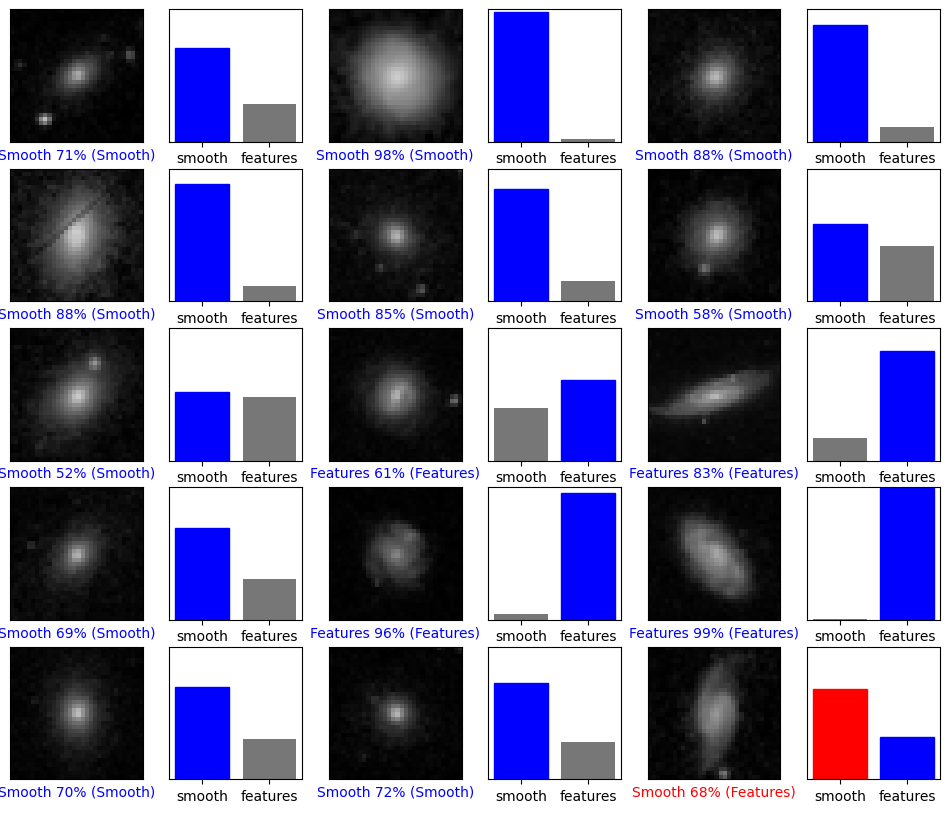

In [91]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()


# Define a new convolutional neural network model

In [62]:
keras.backend.clear_session()
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size, target_size,3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,354 (1.48 MB)

 Trainable params: 388,354 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model on the training data

In [64]:
hist = model.fit(train_data, train_label, epochs=15, validation_split=0.2)

Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.7450 - loss: 0.4983 - val_accuracy: 0.8693 - val_loss: 0.3211
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9047 - loss: 0.2558 - val_accuracy: 0.9240 - val_loss: 0.2147
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9126 - loss: 0.2266 - val_accuracy: 0.9319 - val_loss: 0.1749
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9289 - loss: 0.1893 - val_accuracy: 0.9299 - val_loss: 0.1727
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9413 - loss: 0.1688 - val_accuracy: 0.9541 - val_loss: 0.1338
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9481 - loss: 0.1355 - val_accuracy: 0.9521 - val_loss: 0.1347
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9553 - loss: 0.1280 - val_accuracy: 0.9615 - val_loss: 0.1176
Epoch 8/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9590 - loss: 0.1167 - val_accuracy:

# Now make prediction and visualise
# Compare to previous plot

Text(0.5, 0, 'Epoch')

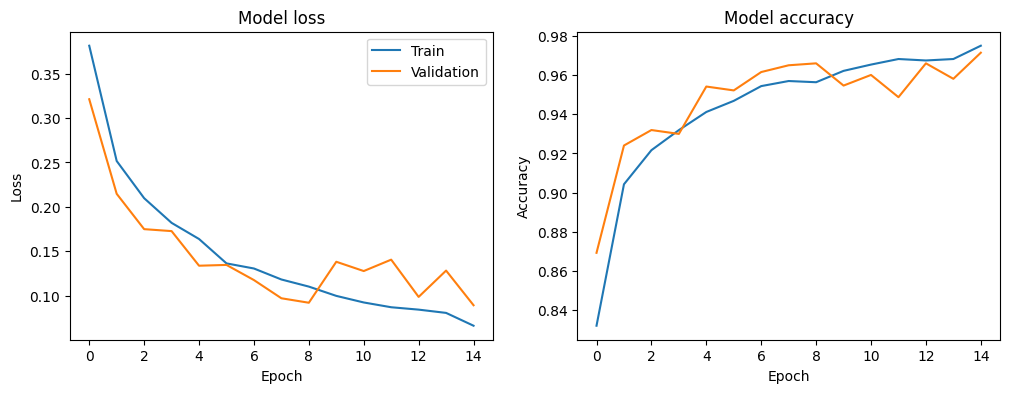

In [65]:
# plot training history again
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


<ipython-input-66-ab1381816075>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-66-ab1381816075>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-66-ab1381816075>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-66-ab1381816075>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  f.axes.set_xticklabels(["smooth","features"])
<ipython-input-66-ab1381816075>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

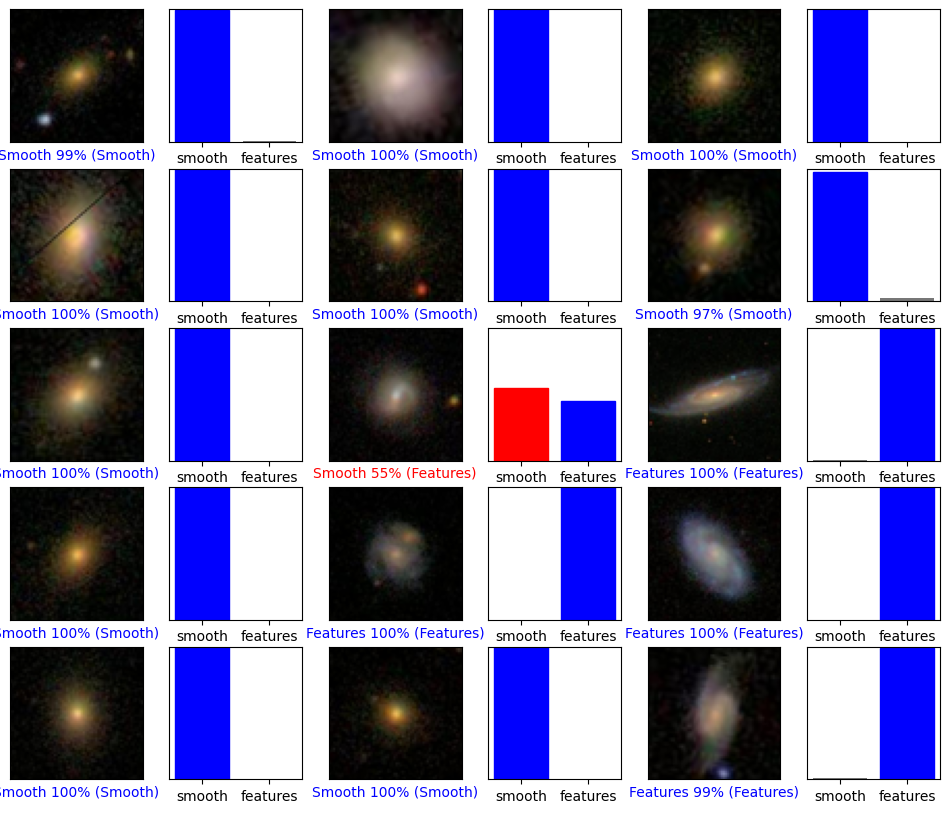

In [66]:
predictions = model.predict(test_data)

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()

# Now add some data augmentations

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=.2,
                             height_shift_range=.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=90,
fill_mode='nearest')
datagen.fit(np.expand_dims(train_data, axis=3))

history = model.fit_generator(datagen.flow(np.expand_dims(train_data, axis=3), train_label, batch_size=30),
                        steps_per_epoch=train_data.shape[0] // 30,
                        epochs=5,
validation_data=(np.expand_dims(test_data, axis=3), test_label))

Epoch 1/5
433/433 [==============================] - 23s 52ms/step - loss: 0.1453 - acc: 0.9462 - val_loss: 0.1044 - val_acc: 0.9632
Epoch 2/5
433/433 [==============================] - 22s 51ms/step - loss: 0.1443 - acc: 0.9479 - val_loss: 0.1166 - val_acc: 0.9588
Epoch 3/5
433/433 [==============================] - 22s 51ms/step - loss: 0.1331 - acc: 0.9515 - val_loss: 0.0957 - val_acc: 0.9676
Epoch 4/5
433/433 [==============================] - 22s 52ms/step - loss: 0.1322 - acc: 0.9505 - val_loss: 0.1032 - val_acc: 0.9624
Epoch 5/5
433/433 [==============================] - 22s 51ms/step - loss: 0.1279 - acc: 0.9537 - val_loss: 0.0677 - val_acc: 0.9779


# Test the trained model on the test data

In [ ]:
test_loss, test_acc = model.evaluate(np.expand_dims(test_data, axis=3), test_label)
print('Test accuracy:', test_acc)

3885/3885 [==============================] - 1s 339us/sample - loss: 0.0677 - acc: 0.9779
Test accuracy: 0.97786355


# Now make prediction and visualise
# Compare to previous plot

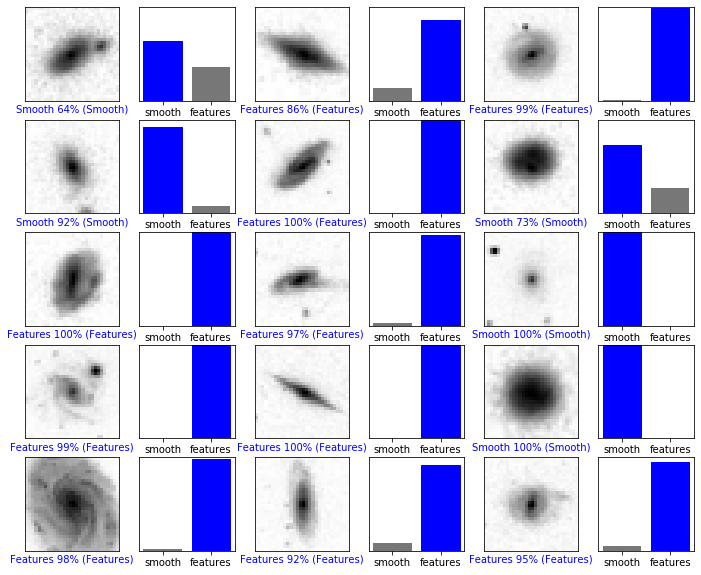

In [ ]:
predictions = (model.predict(np.expand_dims(test_data, axis=3)))

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()